# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

In this assignment you will get familiar with basic and advanced information retrieval concepts. You will implement different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Wednesday, January 31st**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](piazza.com/university_of_amsterdam/spring2018/52041inr6y/home).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [1]:
import logging
import sys
import os
import pickle

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)

        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example
Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [2]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [3]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [4]:
example_document = index.document(index.document_base())
print(example_document)

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [5]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:200])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time'), (16, 'officials'), (17, 'police'), (18, 'bush'), (19, 'soviet'), (20, 'united'), (21, 'national'), (22, '5'), (23, '3'), (24, 'house'), (25, 'american'), (26, 'told'), (27, '10'), (28, 'billion'), (29, 'today'), (30, 'federal'), (31, 'court'), (32, 'made'), (33, 'party'), (34, 'tuesday'), (35, 'city'), (36, 'wednesday'), (37, 'says'), (38, 'company'), (39, 'monday'), (40, 'say'), (41, 'thursday'), (42, 'old'), (43, '4'), (44, 'news'), (45, 'west'), (46, 'did'), (47, 'friday'), (48, 'york'), (49, 'department'), (50, 'four'), (51, 'group'), (52, 'report'), (53, '6'), (54, 'south'), (55, 'military'), (56, 'former'), (57, 'market'), (58, 'called'), (59, 'reported'), (60, 'home'), (61, 'make'), (62, 'spokesman'), (63, 'union'), (64, 'five'), (65, 'month'), (66, '7'), (67, '30')

Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [6]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [7]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [8]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [9]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [10]:
# libraries
import time
import numpy as np
import math
import collections
from collections import Counter
start_time = time.time()

In [11]:
#with open('./ap_88_89/test_topic', 'r') as f_topics:
with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

#______________________we added a list to keep the ext_doc and the tokens in every doc___________
doc_list = []
max_doc_len = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)
    
    #--------------------------------------
    doc_list.append((ext_doc_id,doc_token_ids))
    if(len(doc_token_ids) > max_doc_len):
        max_doc_len = len(doc_token_ids)
    
    #--------------------------------------
    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 43.251365423202515 seconds.


In [15]:
def run_retrieval(model_name, score_fn, hyper_param):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    #-----------------------------------------
    if model_name != 'tfidf' and model_name != 'BM25':
        model_name = model_name + str(hyper_param)
    #-----------------------------------------
    run_out_path = str('models/') + '{}.run'.format(model_name)

#    if os.path.exists(run_out_path):
#        return

    retrieval_start_time = time.time()


    print('Retrieving using', model_name)

    data = collections.defaultdict(list)

    # TODO: fill the data dictionary. 
    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
    
    #for query_id, _ in queries.items():
    for query_id, query_terms in tokenized_queries.items():
        
        score_per_doc = Counter()
        '''
        We do not go through all documents, we just go through the all documents relate to query term.
        For example if we have 5 docs and Q1 = w1 w2 and w1 is inside the doc1 & doc2, w2 is inside doc3
        , then we go through doc1, doc2, doc3
        '''        
        #------------------------docs_to_check = sum of all documents for q:-------------------------
        
        docs_to_check = set([inverted_index[term_id].keys() for term_id in query_terms][0])
        
        '''
        We check the score for every term of a query for every doc related to that query and assign some score
        to them.
        In tf-idf when the term is not inside the that doc, we return 0.
        In the smoothing methods, we assign some probability to the unseen terms.
        '''
        #--------------------------find the score(query, doc)-----------------------------------------
        #for query_term_id in tokenized_queries[query_id]:
        for query_term_id in query_terms:
            for int_doc_id in docs_to_check:
                document_term_freq = get_tf(int_doc_id, query_term_id)
                score_per_doc[int_doc_id] += score_fn(int_doc_id, query_term_id, document_term_freq,hyper_param)
                
        #------------------------make data set to write in run file------------------------------------        
        for int_doc_id in score_per_doc:
            data[query_id].append((score_per_doc[int_doc_id], doc_list[int_doc_id - 1][0]))

    
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)


In [16]:
def get_tf(int_document_id, query_term_id):
    '''
    Returns term frequency (tf_t) for a document
    https://docs.quantifiedcode.com/python-anti-patterns/correctness/not_using_get_to_return_a_default_value_from_a_dictionary.html    
    '''
    if len(inverted_index[query_term_id]) == 0:
        return 0
    else:
        return float(inverted_index.get(query_term_id, 0).get(int_document_id, 0))

def collection_freq(query_term_id):
    #Returns collection frequency
    return collection_frequencies.get(query_term_id, 0)

def calc_p_wc(query_term_id):
    p_wc = collection_freq(query_term_id) / total_terms
    return p_wc

#### TF-IDF without normalization:

In [17]:
def tfidf(int_document_id, query_term_id, document_term_freq,num_docs):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """    
    score = document_term_freq * math.log10(num_docs/len(inverted_index[query_term_id]))
    return score

num_documents = index.maximum_document() - index.document_base()
run_retrieval('tfidf', tfidf,num_documents)

Retrieving using tfidf


### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [18]:
import copy
import gensim
import logging
import pyndri
import pyndri.compat
from operator import itemgetter
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("test")
#from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from scipy import stats

INFO:root:test


In [28]:
def generate_model(model_id,hyper_param,doc,sentences):
    logging.info('Initializing word2vec.')
    
    word2vec_init = gensim.models.Word2Vec(
    size = hyper_param['size'][model_id],             # Embedding size
    window = hyper_param['window'][model_id],         # One-sided window size
    sg = hyper_param['sg'][model_id],                 # Skip-gram.
    min_count = hyper_param['min_count'][model_id],   # Minimum word frequency.
    sample = hyper_param['sample'][model_id],         # Sub-sample threshold.
    hs = hyper_param['hs'][model_id],                 # Hierarchical softmax.
    negative = hyper_param['negative'][model_id],     # Number of negative examples.
    iter = hyper_param['iter'][model_id],             # Number of iterations.
    workers  =hyper_param['workers'][model_id],       # Number of workers.
    )
    
    word2vec_init.build_vocab(sentences, trim_rule=None)
    models = [word2vec_init]
    for epoch in range(1, 6):
        logging.info('Epoch %d', epoch)

        model = copy.deepcopy(models[-1])
        model.train(sentences,total_examples=164597,epochs=model.iter)
    logging.info('Trained models: %s', model)
    
    model_name = str(model_id)+".model"
    
    model.save("models/word2vec_models/"+model_name)    
    return "models/word2vec_models/"+model_name

In [29]:
#https://www.youtube.com/watch?v=ERibwqs9p38
#BOW: sentence vector = sum(verctor[each word in sentence])

#another method: vec_sent = len_sent * sum_on_all_words_in_sent( [alpha/(alpha + p(w))] * vec_w)
#Then v_s = v_s - u * u_T * v_s


'''
https://ciir-publications.cs.umass.edu/pub/web/getpdf.php?id=1248

 Similarly,
Zuccon et al. [33] leveraged word embeddings for the estima-
tion of translation probability between words, and combine
d
the neural translation language model with collection back
-
ground probabilities using the Dirichlet smoothing strate
gy.
All the existing work shows that employing word embed-
ding for IR can improve retrieval effectiveness.  However,
this is achieved by linearly combining an embedding based
model with traditional retrieval models.
'''
hyper_param = {
'size' : [32, 32, 32, 32, 64]
,'window' : [20, 10, 20, 5, 15]
,'sg' : [False, True, True, False, False]
,'min_count' : [5, 5, 5, 5, 5]
,'sample' : [1e-3, 1e-3, 1e-3, 1e-3, 1e-3]
,'hs' : [True,True, True, True, True]
, 'negative' : [10, 10, 10, 10, 10]
, 'iter' : [1, 1, 1, 1, 1]
, 'workers' : [8, 8, 8, 8, 8]
}
model_num = 5

dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)
logging.info('Initializing word2vec.')



INFO:root:Initializing word2vec.


In [30]:
# train word2vec model and save the adress:
model_adrs_dict = {}
for model_id in range(model_num):
    model_name = str(model_id)+".model"
    model_adrs_dict[model_id] = "models/word2vec_models/"+model_name
    #model_adrs_dict[model_id] = generate_model(model_id,hyper_param,doc,sentences)

In [32]:
from gensim import corpora, models, similarities
'''word2vecmodel=gensim.models.Word2Vec.load('word2vec_models/0.model')'''
print(id2token[1],word2vecmodel[0][id2token[1]])
word2vecmodel[0].most_similar(id2token[1])

/home/tharangni/Documents/IR1/IR1/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tharangni/Documents/IR1/IR1/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.
INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors


new [-0.8987588   3.1779993  -0.9737566   1.9757984   3.2451627  -3.805465
  1.6622778  -6.310378   -4.0763583  -4.883889    0.9928312  -2.01476
  4.7577724   1.0475444   2.7670574  -5.308079   -3.740314   10.233902
 -2.9538803   1.4023079  -4.344732   -1.3738114   4.789927    0.6801642
  2.4650445   0.88017404 -0.2444992   1.1469553   7.5878077   4.03774
  0.32422838 -5.215157  ]


[('snydergeneral', 0.7862908244132996),
 ('olympia', 0.7525001764297485),
 ('states', 0.7224745154380798),
 ('knicks', 0.7186657190322876),
 ('upstate', 0.7158376574516296),
 ('telespectrum', 0.6931784152984619),
 ('illuminating', 0.6641134023666382),
 ('nations', 0.6555997729301453),
 ('ratifications', 0.6504614353179932),
 ('odwyer', 0.6468589305877686)]

In [34]:
def parse_data_set(path):
    file = open(path, 'r')    
    top1000 = collections.defaultdict(list)
    top_docs_set = set()
    for line in file:
        info =line.split()
        top1000[info[0]].append((info[2],info[4]))
        top_docs_set.add(info[2])
    return top1000,top_docs_set
        


In [66]:
def generate_query2vec(model,top1000,embed_size):
    query2vec = collections.defaultdict(list)
    #------------make vector for the query------------------
    query_vec = {}
    for query_id, query_term in tokenized_queries.items():
        sum_vec = np.zeros(embed_size)
        counter = 0
        for term_id in query_term:
            if term_id > 0 and id2token[term_id] in model :
                sum_vec += np.copy(model[id2token[int(term_id)]])
                counter +=1
        if(counter):
            query_vec[query_id] = sum_vec/counter
            
        # if no words where in dictionary then we will not add it to query_vec
        #else:
            #query_vec[query_id] = np.full(embed_size, -np.inf)#----------------has to check--------------
            #-????????????????????should this be 0 or -inf for a query with completely new words???????
    return query_vec                



/home/tharangni/Documents/IR1/IR1/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/home/tharangni/Documents/IR1/IR1/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [41]:
def save_to_file(my_obj, path,obj_name):
    with open(str(path)+str(obj_name)+'.pkl', 'wb') as f:
        pickle.dump(my_obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_from_file(path,obj_name):
    with open(str(path)+str(obj_name), 'rb') as handle:
        b = pickle.load(handle)
    return b

In [ ]:
def generate_doc2vec(model,top_docs_set,embed_size):
    doc_vec = {}
    for doc_ex_id in top_docs_set:
        
        #---------------find doc words---------------
        for indx, doc_info in enumerate(doc_list):
            if doc_info[0] == doc_ex_id:
                doc_terms = doc_info[1]
                doc_id = indx+1
                break                

        sum_vec = np.zeros(embed_size)
        counter = 0
        for term_id in doc_terms:
            if term_id > 0 and id2token[term_id] in model :
                sum_vec += np.copy(model[id2token[int(term_id)]])
                counter +=1
        if(counter):
            doc_vec[doc_ex_id] = sum_vec/counter
            
        
        #else:
         #   doc_vec[doc_ex_id] = np.full(embed_size, -np.inf)#----------------has to check--------------
            #-????????????????????should this be 0 or -inf for a query with completely new words???????
    return doc_vec 

In [72]:
def find_cosine_similarity(top1000_tfidf, document2vec, query2vec):
    word2vec_cosine_similarity = collections.defaultdict(list)
    ''' query_id = '93'
    related_docs = top1000_tfidf['93']'''
    for query_id, related_docs in top1000_tfidf.items():
        for doc_info in related_docs: 
            if query_id in query2vec and doc_info[0] in document2vec:
                sim = (1 - spatial.distance.cosine(query2vec[query_id],document2vec[doc_info[0]]),doc_info[0])
                #query_id --> (document_score, external_doc_id)
                word2vec_cosine_similarity[query_id].append((sim))
    return word2vec_cosine_similarity


query_doc_path = 'models/word2vec_models/query_doc_info/'
#query2vec = load_from_file(query_doc_path, str(model_id)+'_query2vec.pkl')#load query vectors
query2vec = generate_query2vec(word2vecmodel[0],top1000_tfidf,hyper_param['size'][0])
document2vec = load_from_file(query_doc_path, str(model_id)+'_document2vec.pkl')#load doc vector
word2vec_cosine_similarity = find_cosine_similarity(top1000_tfidf, document2vec, query2vec)

/home/tharangni/Documents/IR1/IR1/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/home/tharangni/Documents/IR1/IR1/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [92]:
def write_to_file_word2vec_doc2vec(top1000_list,top_docs_set,model_path,model_num,path_to_save):
    word2vecmodel = {}
    for model_id in range(model_num):
        print(model_id)
        word2vecmodel[model_id]=gensim.models.Word2Vec.load(model_path + model_adrs_dict[model_id])#load model
        
        query2vec = generate_query2vec(word2vecmodel[model_id],top1000_list,hyper_param['size'][model_id])#make query vectors
        save_to_file(query2vec, path_to_save ,str(model_id)+"_query2vec")
        
        document2vec= generate_doc2vec(word2vecmodel[model_id],top_docs_set,hyper_param['size'][model_id])#make doc vectors
        save_to_file(document2vec, path_to_save,str(model_id)+"_document2vec")
        
def generate_word2vec_similarity_file(top1000_list,top_docs_set,model_path,model_num,query_doc_path):   
    for model_id in range(model_num):
        query2vec = load_from_file(query_doc_path, str(model_id)+'_query2vec.pkl')#load query vectors
        document2vec = load_from_file(query_doc_path, str(model_id)+'_document2vec.pkl')#load doc vector
        word2vec_cosine_similarity = find_cosine_similarity(top1000_list, document2vec, query2vec)#find similarities between queries and docs
        
        model_name = str(model_id)+ '_sim'
        run_out_path = str('models/word2vec_models/') + '{}.run'.format(model_name)
        with open(run_out_path, 'w') as f_out:
            write_run(
                model_name=model_name,
                data=word2vec_cosine_similarity,
                out_f=f_out,
                max_objects_per_query=1000) 

In [88]:
data_path = 'models/tfidf.run' 
top1000_tfidf,top_docs_set = parse_data_set(data_path) 
model_adrs_dict = {
    0:"0.model"
    ,1: "1.model"
    ,2:"2.model"
    ,3:"3.model"
    , 4:"4.model"
    }
model_path = "models/word2vec_models/"
model_num = 5 #amount of models we have
query_doc_path = 'models/word2vec_models/query_doc_info/'
write_to_file_word2vec_doc2vec(top1000_tfidf,top_docs_set,model_path,model_num,query_doc_path)   

INFO:gensim.utils:loading Word2Vec object from models/word2vec_models/4.model


4


INFO:gensim.utils:loading wv recursively from models/word2vec_models/4.model.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute syn0norm to None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:loaded models/word2vec_models/4.model
/home/tharangni/Documents/IR1/IR1/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/home/tharangni/Documents/IR1/IR1/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/home/tharangni/Documents/IR1/IR1/lib/python3.5/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  fro

In [84]:
top1000_tfidf['93']

[('AP890829-0102', '15.232736911188148'),
 ('AP880310-0257', '10.645610638010483'),
 ('AP890524-0036', '10.444454203418651'),
 ('AP891218-0109', '9.39539008842142'),
 ('AP880621-0065', '9.304089883829642'),
 ('AP890105-0173', '9.254608654239924'),
 ('AP880425-0042', '8.984983286662528'),
 ('AP880916-0009', '8.957889209774915'),
 ('AP880620-0116', '8.711082672887192'),
 ('AP880420-0103', '8.571726320771678'),
 ('AP880718-0041', '8.39197607572008'),
 ('AP880922-0172', '8.344900891358211'),
 ('AP890619-0088', '8.148975503182903'),
 ('AP890222-0097', '8.013450278361216'),
 ('AP881221-0163', '7.8431938850075404'),
 ('AP880226-0113', '7.798968864777631'),
 ('AP891012-0124', '7.570718353298185'),
 ('AP881104-0271', '7.555968292240454'),
 ('AP880420-0210', '7.38571189888678'),
 ('AP880622-0190', '7.295836776360981'),
 ('AP880509-0052', '7.205961653835183'),
 ('AP880605-0080', '7.023361244651626'),
 ('AP880606-0019', '6.827435856476318'),
 ('AP890930-0008', '6.792704687944331'),
 ('AP880708-001

In [86]:
document2vec

{'AP890424-0215': array([ 0.47072174, -0.22036628, -0.09320823,  0.03116874,  0.21923277,
        -0.36273442, -0.79480696,  0.62305073,  0.18806489, -0.31299902,
        -0.15089243,  0.34829699, -0.58656591, -1.40161815,  0.08206398,
         0.3738728 ,  0.49957903,  0.13713625,  0.16511935, -0.00728636,
         0.06072117,  0.5099892 , -0.09261133,  0.29691591, -0.41589149,
        -0.29612625,  0.02336303,  0.20375081, -0.09930103, -0.45138516,
         1.41871622, -0.36190036]),
 'AP881003-0343': array([-1.26492465, -1.0283445 , -0.41939838, -1.79110661,  0.75354307,
        -0.1560524 , -0.23580793, -1.42857945,  0.06521538, -1.21830761,
        -0.26731315, -0.06353705, -0.2251785 , -0.91680616, -0.24899359,
         0.3748368 ,  0.57147278,  0.62932609,  0.63003631,  0.03384677,
         0.13071387, -0.22500335, -0.71834977,  0.50835611, -1.20746654,
        -0.25000467, -1.10971217, -0.63592139, -0.7029406 ,  0.13651585,
        -0.10565774, -2.50691125]),
 'AP890228-0204': 

In [91]:
query_doc_path = 'models/word2vec_models/query_doc_info/'
generate_word2vec_similarity_file(top1000_tfidf,top_docs_set,model_path,model_num,query_doc_path)

In [106]:
import pprint
from collections import defaultdict

def parse_results(results_file):
    results_lines = [l.strip('\n') for l in open(results_file, 'r').readlines()]
    eval_measure = None
    results_by_scoring = defaultdict(lambda: defaultdict(dict))
    results_by_eval = defaultdict(lambda: defaultdict(dict))
    means = defaultdict(lambda: defaultdict(float))
    
    for line in results_lines:
        if line.startswith('MODEL:'):
            scoring_method = line.split(': ')[1]
            continue
        else:
            eval_measure, query, result = line.split()
            if query == 'all':
                means[eval_measure][scoring_method] = result
            else:
                results_by_scoring[scoring_method][eval_measure][int(query)] = float(result)
                
    for scoring_method in results_by_scoring.keys():
        for eval_measure in results_by_scoring[scoring_method].keys():
            for query, result in results_by_scoring[scoring_method][eval_measure].items():
                results_by_eval[eval_measure][scoring_method][query] = float(result)

    return means, results_by_scoring, results_by_eval
    
means, scoring_dict, eval_dict = parse_results('results_word2vec_validation.txt')



language_models = {
    '_sim' : [setting for setting in list(means['ndcg_cut_10']) 
                              if setting.startswith('0_sim') or setting.startswith('1_sim') or setting.startswith('2_sim') or setting.startswith('3_sim') or setting.startswith('4_sim')]
#     '1_sim' : [setting for setting in list(means['ndcg_cut_10']) 
#                    if setting.startswith('1_sim')],
#     '2_sim' : [setting for setting in list(means['ndcg_cut_10']) 
#                         if setting.startswith('2_sim')],
#     '3_sim' : [setting for setting in list(means['ndcg_cut_10']) 
#                         if setting.startswith('3_sim')],
#     '4_sim' : [setting for setting in list(means['ndcg_cut_10']) 
#                         if setting.startswith('4_sim')]
    #'plm500' : [setting for setting in list(means['ndcg_cut_10']) 
    #                    if setting.startswith('plm500')],
    #'plm1500' : [setting for setting in list(means['ndcg_cut_10']) 
    #                    if setting.startswith('plm1500')]
}


#pprint(language_models)

In [217]:
from itertools import product
from itertools import combinations
from scipy import stats
from statsmodels.sandbox.stats import multicomp
np.random.seed(12345678)

relevance_grades  = ['s0', 's1', 's2', 's3', 's4']
rankings = [ranking for ranking in combinations(relevance_grades, 2)]
print(rankings)

[('s0', 's1'), ('s0', 's2'), ('s0', 's3'), ('s0', 's4'), ('s1', 's2'), ('s1', 's3'), ('s1', 's4'), ('s2', 's3'), ('s2', 's4'), ('s3', 's4')]


In [218]:
#['ndcg_cut_10', 'map_cut_1000', 'recall_1000', 'P_5']
#['4_sim', '3_sim', '2_sim', '0_sim', '1_sim']
#print(eval_dict['ndcg_cut_10']['0_sim'])
'''
S0 AND S4 RECEIVE A NAN PVALUE. WE THINK THIS IS BECAUSE THE NDCG@10 VALUES DON'T SEEM TO BE SIGNIFICANTLY DIFFERENT. 
SO WE CONVERT THIS TO 0 BEFORE PASSING FOR BONFERRONI TEST. AND EVENTUALLY THIS TURNS OUT TO BE THE BEST MODEL.
IN THE END WE CHOOSE S0 (DUE TO 32 EMBEDDING SIZE AND 20 WINDOW SIZE(?)) [CHOOSE THE MODEL WITH LESS FEATURES]
'''
s0_ndcg = np.array(list(eval_dict['ndcg_cut_10']['0_sim'].values()), dtype = float)
s1_ndcg = np.array(list(eval_dict['ndcg_cut_10']['1_sim'].values()), dtype = float)
s2_ndcg = np.array(list(eval_dict['ndcg_cut_10']['2_sim'].values()), dtype = float)
s3_ndcg = np.array(list(eval_dict['ndcg_cut_10']['3_sim'].values()), dtype = float)
s4_ndcg = np.array(list(eval_dict['ndcg_cut_10']['4_sim'].values()), dtype = float)

models_available  = [s0_ndcg, s1_ndcg, s2_ndcg, s3_ndcg, s4_ndcg]
model_combination = [ranking for ranking in combinations(models_available, 2)]
multiple_p_values = [] 

#print(model_combination[0][0], '\n',model_combination[0][1])

for item in model_combination:
    t_test = stats.ttest_rel(item[0],item[1])
    if str(t_test.pvalue) != 'nan':
        multiple_p_values.append(t_test.pvalue)
    else:
        multiple_p_values.append(int(0))
multiple_p_values = np.array(multiple_p_values)

print(multiple_p_values)

#multiple comparisons problem
multiple_comparison = multicomp.multipletests(multiple_p_values, alpha = 0.05, method = 'bonferroni')

print(multiple_comparison)
print(Counter(eval_dict['ndcg_cut_10']['0_sim'].values())[0.0])
print(Counter(eval_dict['ndcg_cut_10']['4_sim'].values())[0.0])


[0.53642468 0.64198782 0.04994218 0.         0.8584213  0.19318518
 0.53642468 0.23711256 0.64198782 0.04994218]
(array([False, False, False,  True, False, False, False, False, False,
       False]), array([1.        , 1.        , 0.49942183, 0.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.49942183]), 0.005116196891823743, 0.005)
12
12


In [113]:
import pandas as pd

means_df = pd.DataFrame.from_dict(means)
means_df

,P_5,map_cut_1000,ndcg_cut_10,recall_1000
0_sim,0.3200,0.1375,0.2895,0.3676
1_sim,0.2667,0.1294,0.2713,0.3676
2_sim,0.2867,0.1297,0.2739,0.3676
3_sim,0.2400,0.1120,0.2339,0.3676
4_sim,0.3200,0.1375,0.2895,0.3676


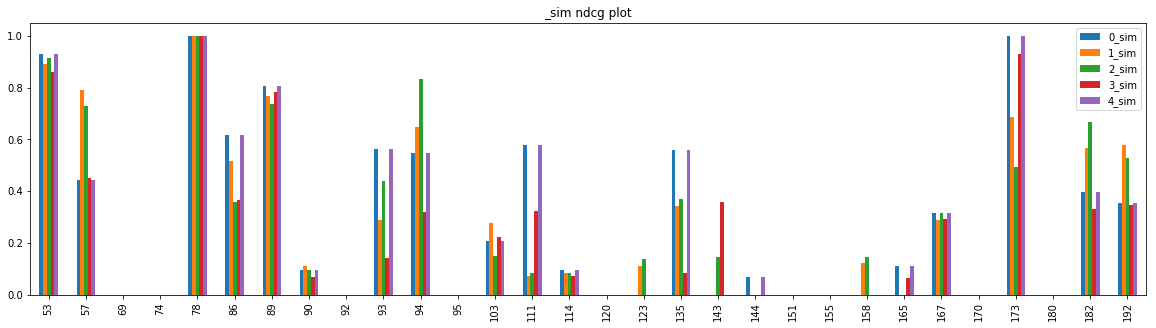

In [107]:
import matplotlib.pyplot as plt
import numpy as np

for model in language_models.keys():
    dicts = { setting : eval_dict['ndcg_cut_10'][setting] for setting in language_models[model] }
    ndcg_df = pd.DataFrame.from_dict(dicts) 
    ndcg_df.plot.bar(figsize=(20,5))
    plt.title(model + ' ndcg plot')
    plt.show()

### Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

### Task 4: Write a report [15 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
